# The Timeseries Quantum Autoencoder
*TS QAE in PennyLane+PyTorch with angle encoding of TS sliding windows*

**By:** Jacob Cybulski and AInterns<br>
**Date:** August 2023 - September 2026<br>
**Aims:**
- The goal of this notebook is to build a Time Series Quantum Autoencoder.
- This particular notebook aims to build and test a pure PennyLane QAE.

**Sources:**
1. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.
2. Ali Shannon, "techshot25/Autoencoders", accessed March 12, 2024, https://github.com/techshot25/Autoencoders.
3. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
4. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.

**Notes:**
- Refer to a separate "versions" notebook for the log of changes
- <font color="red"><strong>This is a very quick implementation - very slow and very very inaccurate</strong><font>

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.',
 '..']

In [3]:
import matplotlib.pyplot as plt
import pylab
import math
import copy
import os.path as path
import time
import warnings

from IPython.display import clear_output

from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Charts import multi_plot_flat_ts, meas_plot
from qae_utils.Tools import draw_circuit
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
from qae_utils.Window import ts_calc_noise, ts_add_noise

from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

## Load dataset hyper-parameters

In [4]:
### Identify data to loaded
DATA_ID = 'mackey_glass_tau17_n200'

In [5]:
### Constants
LOG_NAME = 'aintern'
CASE_NAME = 'full_qae'
DATA_PATH = f'{LOG_NAME}/data'
FIGURES_PATH = f'{LOG_NAME}/figures'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'

### Create a folder if needed
create_folder_if_needed(FIGURES_PATH)
create_folder_if_needed(TRAIN_PATH)
create_folder_if_needed(PARAMS_PATH)
create_folder_if_needed(ANALYSIS_PATH)

### Show constants
(LOG_NAME, CASE_NAME, DATA_ID, DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, FIGURES_PATH)

('aintern',
 'full_qae',
 'mackey_glass_tau17_n200',
 'aintern/data',
 'aintern/training',
 'aintern/params',
 'aintern/analysis',
 'aintern/figures')

In [6]:
# Load repository info
data_info_path = f'{DATA_PATH}/{DATA_ID}/info.json'
data_info = read_json_file(data_info_path)
data_info

{'data_name': 'mackey_glass_tau17',
 'major_version': 6,
 'minor_version': 1,
 'samples': 200,
 'scale_margin': 0.2,
 'scale_low': 0.2,
 'scale_high': 0.8,
 'mackey_glass_len': 1200,
 'mackey_glass_beta': 0.2,
 'mackey_glass_gamma': 0.1,
 'mackey_glass_n': 10,
 'mackey_glass_tau': 17,
 'mackey_glass_x0': 1.2}

In [7]:
### Set the version of this notebook
major_version = 6
minor_version = 1
debug_level = 2

In [8]:
### Load all data hyper-parameters

# Software version
data_major_version = data_info['major_version']
data_minor_version = data_info['minor_version']

# Data settings
samples = data_info['samples']
scale_margin = data_info['scale_margin']
scale_low = data_info['scale_low']
scale_high = data_info['scale_high']

### Load previously saved TSs

In [9]:
### Define file names
#   Note that data files have alreay been 0..pi encoded
x_org_fpath = f'{DATA_PATH}/{DATA_ID}/x_org.arr'
y_org_fpath = f'{DATA_PATH}/{DATA_ID}/y_org.arr'

In [10]:
### Load the data set
X = read_ts_file(x_org_fpath).astype(int)
y = read_ts_file(y_org_fpath)

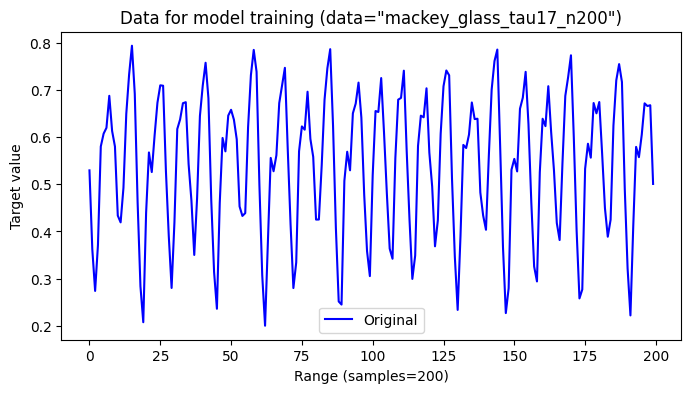

In [11]:
### Plot loaded TSs
X_list = [0]
y_list = [y]

# print(f'y_train_ts.shape = {y_train_ts.shape}')
# print(f'y_test_ts.shape = {y_test_ts.shape}')

print()
multi_plot_flat_ts(y_list, X_list=X_list,
    colors = ['blue'],
    labels = ['Original'],
    lines = ['solid'], legend_cols=1, 
    rcParams=(8, 4), #ylim=(0, 3.5),
    xlabel=f'Range (samples={samples})',
    title=f'Data for model training (data="{DATA_ID}")'
    )
print()

## Building and training a Quantum Autoencoder

In [12]:
### Libraries used in QAE development

# PennyLane imports
import pennylane as qml
from pennylane import numpy as np

### Define the training file's prefix

In [13]:
### All created files have the following codes:
#   n: sample size
#   w: window size
#   ws: window step
#   z: level of noise injected
#   zr: replication number of noisy records
TRAIN_PREF = f'{CASE_NAME}_{DATA_ID}'
TRAIN_PREF

'full_qae_mackey_glass_tau17_n200'

### Torch utilities

In [14]:
### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Gets all pytorch parameters
def get_param_vals(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    params = params.cpu().detach().flatten() # [0]
    return params.numpy()

### QAE training parameters (Note: they can be taken from a test script)

In [15]:
### Run specific architectural + training param
#   These parameter values can be set from the test data

### Data params
split = 0.75
train_size = int(samples*split)     # Use the first train_size points for training
test_size = samples - train_size    # Use the next test_size points for testing

wind_size = 5
wind_step = 2
horizon = 1

noise = 0.1 # This is max absolute, in relation to value range (0, 1)

### Model params
rot = 'Rxyz' # Ry / Rxyz
n_layers = 4
n_latent = 3
n_extra = 2
n_epochs = 200 # 1000 # 2000
log_interv = 1
param_scaler = 0.1

### Derived params
n_trash = wind_size - n_latent
n_data = n_latent + n_trash
n_wires = n_latent + n_trash + n_extra

### Other (CASE_NAME) invariant params
diff_method = 'best'
interface = None # we will use default
level='gradient'
shuffle_interv = 0
cost_type = 'MSE'
cost_yscale = 'linear' # linear, log
shots = None # We use a state vector simulator

### Currently are not generated here, but QAE models should run 10 times with diff inits
#   The number of times the model should be run with different initial params
#   Each instance history and params should be saved and later used
n_inst = 1

### Random seed(s)
#   We may need to create different seeds for each model instance

seed = 2024

if seed == 0: 
    np.random.seed(rand_seed())
else:
    np.random.seed(seed)
inst_seeds = [int(n) for n in np.random.randint(0, high=9999, size=n_inst)]

### Simulator device

In [16]:
### Quantum simulator
sim = 'default.qubit' # default.qubit lightning.qubit lightning.gpu

### QAE trainnig utilities

In [17]:
### Create time series tensor data with optional noise (note that windows overlap by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2):
    y_ts = ts_wind_make(ts_add_noise(y, noise), wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(y_ts))])
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = np.tensor(X_train_ts, requires_grad=False)
    y_train_tens = np.tensor(y_train_ts, requires_grad=False)
    X_test_tens = np.tensor(X_test_ts, requires_grad=False)
    y_test_tens = np.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [18]:
### Our own gradient-friendly loss/cost function
#   Beware in PennyLane these MUST be very pure
#   to be differentiable (so not external / fancy functions)
def mse_cost_on_tensors(targets, predictions):
    cost = 0
    vals = 0
    for i in range(len(targets)):
        for w in range(len(targets[i])):
            cost = cost + (targets[i][w] - predictions[i][w]) ** 2
            vals += 1
    cost = cost / vals
    return cost

### The cost function generator
def cost_fun_gen_on_tensors(model, cost_fun):
    def _cost_fun(params, inputs, targets):
        nonlocal model, cost_fun
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

## Define, train and test a model
*Note that the trainnig model will be used further, however, the testting model is used only as a reference for its structural properties. The actual testing models will be generated dynamically.*

### Model creation

In [19]:
### Estimates the shape of the "half_qae_enc_with_swap"
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_layers: number of layers (repeats)
#   returns: shape
def full_qae_shape(n_latent, n_trash, n_extra=0, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    return shape

In [20]:
### Full-QAE Circuit: Input + Encoder + Decoder + Output + No Swap Test
#   wires: list/array of wires to create a full QAE
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_extra: number of additional qubits to increase circuit breadth
#   n_layers: number of layers (repeats)
#   rot: rotation type, 'Ry' or 'Rxyz'
#   add_outseq: if True, the inverse of the input sequence will be added on output
#     If so, data needs to be split into input and output sequence
#   invert_dec: If True the decoder ansatz will be inverted
#   returns: QAE building function which takes arguments
#     inputs: list/array of input values to be angle encoded
#     weights: list/array of weights shaped to be used in ansatz blocks

def full_qae(wires, n_latent, n_trash, n_extra, n_layers=1, rot='Ry', add_outseq=True, invert_dec=True):

    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    extra_wires = wires[n_latent+n_trash:]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires + extra_wires

    ### Encodes a sequence on in put (similar to AngleEncoding)
    def _sequence_encoder(wires, inputs):
        n_inputs = len(inputs)
        n_wires = len(wires)
    
        for w in wires:
            # qml.Hadamard(wires=w)
            if w > n_inputs-1:
                qml.RY(0, wires=w)
            else:
                qml.RY(inputs[w], wires=w)

    ### Entangler shape
    def _entangler_shape(n_layers, n_wires, rot='Ry'):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return ()

    ### Entangler
    def _entangler(wires, weights, rot='Ry'):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=anz_wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=anz_wires)

    ### Full QAE encoder
    def _full_qae(weights, inputs):
        
        nonlocal wires, n_latent, n_trash, n_extra, n_layers, rot
        nonlocal latent_wires, trash_wires, extra_wires, data_wires, anz_wires
        nonlocal add_outseq, invert_dec
                
        n_anz_wires = n_latent + n_trash + n_extra 
        n_data = n_latent + n_trash
    
        # Add input encoder
        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)
    
        # Find encoder/decoder shapes
        #    This function assumes symmetric QAE so they are identical
        enc_weights_shape = _entangler_shape(n_layers, n_anz_wires, rot=rot)
        dec_weights_shape = enc_weights_shape
     
        # Split and shape weights for encoder and decoder ansatze
        enc_weights = weights[:n_layers].reshape(enc_weights_shape)
        dec_weights = weights[n_layers:].reshape(dec_weights_shape)

        # Add encoder ansatz
        _entangler(anz_wires, enc_weights, rot=rot)        
      
        # Add initialisation of trash and extra space
        qml.Barrier(wires)
        for w in trash_wires: qml.measure(w, reset=True)
        for w in extra_wires: qml.measure(w, reset=True)
        qml.Barrier(wires)
    
        # Add decoder ansatz
        if invert_dec:
            qml.adjoint(_entangler)(anz_wires, dec_weights, rot=rot)
        else:
            _entangler(anz_wires, enc_weights, rot=rot)
        qml.Barrier(wires)
    
        # Add output sequence if needed
        if add_outseq:
            qml.adjoint(_sequence_encoder)(data_wires, inputs)
            
        return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]
        # return qml.probs(wires=data_wires)
    return _full_qae

In [21]:
%%script true
test_latent = 3; test_trash = 2; test_extra = 1; test_layers=2
test_inputs = test_latent + test_trash
test_wires = test_latent + test_trash + test_extra
test_wires = list(range(test_wires))
test_rot = 'Ry'

test_shape = full_qae_shape(test_latent, test_trash, test_extra, n_layers=test_layers, rot=test_rot)
test_n_weights = np.prod(test_shape)
print(f'Full-QAE shape: {test_shape}, weights: {int(test_n_weights)}\n')

test_data = torch.linspace(100, 200, test_inputs, requires_grad=False)
test_weights = torch.rand(test_shape, requires_grad=True)

print(f'Data ({test_data.shape}): \n{test_data}\n')
print(f'Weights ({test_weights.shape}): \n{test_weights}\n')

In [22]:
%%script true
### Testing full-QAE for training

# Define a static full-QAE
test_qae = full_qae(test_wires, test_latent, test_trash, test_extra, n_layers=test_layers, rot=test_rot, add_outseq=True, invert_dec=True)

# Create and draw a full-QAE
test_dev = qml.device(sim, wires=test_wires, shots=shots)
test_qae_qc = qml.QNode(test_qae, test_dev)
draw_circuit(test_qae_qc, scale=0.7, title='Full-QAE Decoder+Output', level='device') \
    (test_weights, test_data) # expansion_strategy='device'/'gradient'

## Create and train the model
Test the model with sample parameters and data

Full-QAE shape: (8, 7, 3), weights: 168



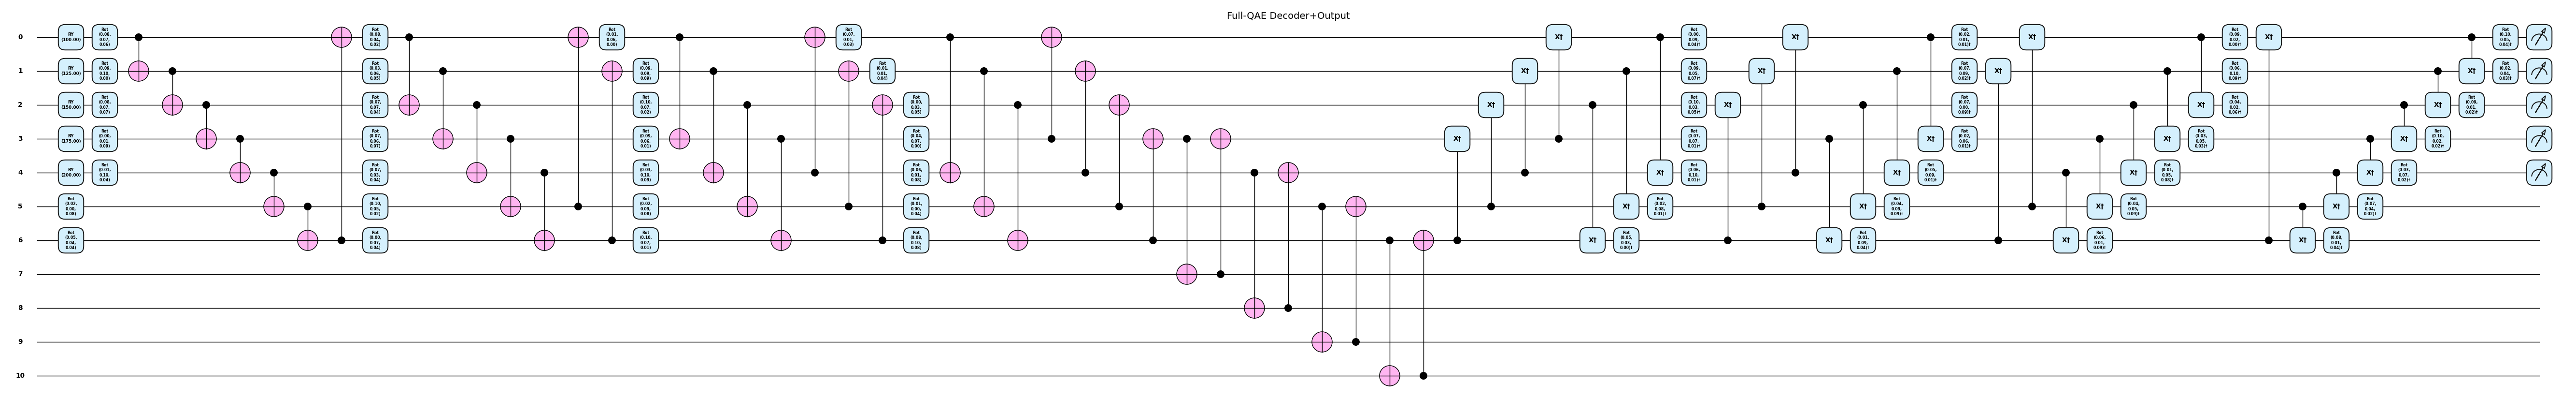

In [23]:
##### Create a model

wires = list(range(n_wires))

### Check the QAE shape
shape = full_qae_shape(n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)
print(f'Full-QAE shape: {shape}, weights: {int(n_weights)}\n')

### Select the random initial parameters to match the ansatz shape
sample_params = np.random.uniform(high=param_scaler, size=shape, requires_grad=True)
sample_data = np.linspace(100, 200, n_data, requires_grad=False)

qae = full_qae(wires, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot, add_outseq=False, invert_dec=True)

# Create and draw a full-QAE
reserve_wires = 4
dev = qml.device(sim, wires=n_wires+reserve_wires, shots=shots, seed=seed)
qae_model = qml.QNode(qae, dev)
draw_circuit(qae_model, scale=0.7, title='Full-QAE Decoder+Output', level='device') \
    (sample_params, sample_data) # expansion_strategy='device'/'gradient'

In [24]:
##### Prepare for training

### For reproducibility
np.random.seed(seed)

### Select one of the following optimisers built into PennyLane
# opt = qml.GradientDescentOptimizer(stepsize=0.5)
# opt = qml.RMSPropOptimizer(stepsize=0.1, decay=0.7, eps=1e-08)
# opt = qml.NesterovMomentumOptimizer(stepsize=0.5)
# opt = RCDOptimizer(h=0.1)
opt = qml.AdamOptimizer(stepsize=0.5)

In [25]:
%%script true
### Test I/O for the QAE
if debug_level > 1:
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, 
        wind_size=wind_size, wind_step=wind_step)
    _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, 
        wind_size=wind_size, wind_step=wind_step)
    results_pure_tens = qae_model(sample_params, X_noisy_tens)
    pred_pure_tens = np.stack(results_pure_tens)
    print(f'X noisy={X_noisy_tens.shape}: \n{X_noisy_tens[0:3]}\n')
    print(f'y pure=({y_pure_tens.shape}[0:3]): \n{y_pure_tens[0:3]}\n')
    print(f'y pred=({pred_pure_tens.shape}[0:3]):\n{pred_pure_tens[0:3]}\n')
    print(f'cost: {cost_fun(sample_params, X_noisy_tens, y_pure_tens)}')  

In [26]:
##### Training loop

def train_with_noise(model, X, y, loss_fun, optimizer, n_epochs, init_weights=None, 
                     log_interv=100, prompt_fract=0.1, start_time=0, level=2, seed=0,
                     wind_size=8, wind_step=4, noise=0, weight_scaler=0.1):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Define the cost function
    cost_fun = cost_fun_gen_on_tensors(model, loss_fun)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    
    ### Set initial weights/parameters
    if init_weights is None:
        init_weights = np.random.uniform(high=np.pi, size=shape, requires_grad=True)*weight_scaler
    params = init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, 
        wind_size=wind_size, wind_step=wind_step)
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, 
            wind_size=wind_size, wind_step=wind_step)
    
        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, X_noisy_tens, y_pure_tens), params)
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):04d} sec) cost={np.round(cost, 6)}')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

In [27]:
hist_cost, hist_params, init_weights, stats = train_with_noise(qae_model, 
    X, y, mse_cost_on_tensors, opt, n_epochs,
    wind_size=wind_size, wind_step=wind_step, noise=noise, # needed to dynamically create noise
    log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=seed)

Iter: 000 (0005 sec) cost=0.089083
Iter: 020 (0120 sec) cost=0.021037
Iter: 040 (0234 sec) cost=0.010948
Iter: 060 (0348 sec) cost=0.007918
Iter: 080 (0462 sec) cost=0.105509
Iter: 100 (0577 sec) cost=0.021239
Iter: 120 (0692 sec) cost=0.013427
Iter: 140 (0806 sec) cost=0.009802
Iter: 160 (0921 sec) cost=0.008069
Iter: 180 (1035 sec) cost=0.007718

Training completed: epochs=200, min cost=0.006567 @ 74, time=1144 secs



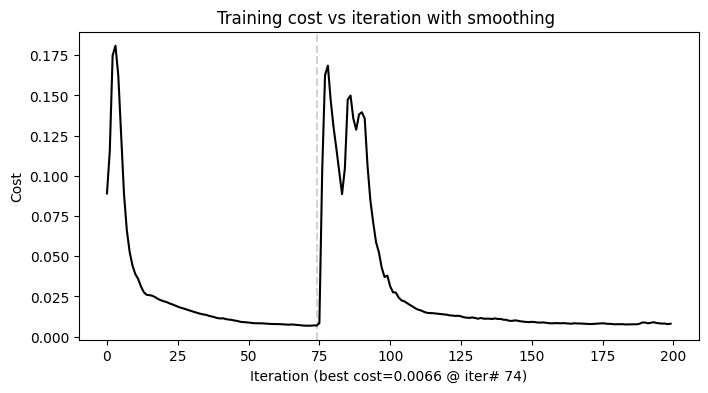

In [28]:
### Plot training cost
#   Note that best model may not have been saved
#   because models are being saved at predefined intervals (log_interv)
meas_plot(hist_cost, meas='cost', task='min', title_pref='Training',
    rcParams=(8, 4), log_interv=log_interv,
    backplot=False, back_color='linen', smooth_weight=0.6,
    save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/train_sample_cost.eps')

### Save training history

In [29]:
### Save the current model results info the log 
from qae_utils.Files import write_pickle_file
inst = n_inst-1 # There is only one at the moment
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/hist.pkl'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/init.pkl'
params_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/inst_{inst:03d}/params.pkl'
write_pickle_file(history_fpath, hist_cost)
write_pickle_file(init_fpath, init_weights.numpy())
write_pickle_file(params_fpath, np.stack(hist_params).numpy())

## Test the trained model

### Create test data, pure and with noise
*Test both pure and noisy TSs*

In [30]:
### Add noise to pure data to create a sample noisy data

# Create a sample of pure and noisy training and test tensors
X_train_pure_tens, y_train_pure_tens, X_test_pure_tens, y_test_pure_tens = \
    create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)
X_train_noisy_tens, y_train_noisy_tens, X_test_noisy_tens, y_test_noisy_tens = \
    create_sw_tens(X, y, noise=noise, wind_size=wind_size, wind_step=wind_step)

# Flatten original TSs for plotting
y_train_pure_flat = ts_wind_flatten_avg(y_train_pure_tens, wind_step)
y_test_pure_flat = ts_wind_flatten_avg(y_test_pure_tens, wind_step)
y_train_noisy_flat = ts_wind_flatten_avg(y_train_noisy_tens, wind_step)
y_test_noisy_flat = ts_wind_flatten_avg(y_test_noisy_tens, wind_step)

calc_noise, _, _ = ts_calc_noise(y_train_pure_tens, y_train_noisy_tens)
calc_noise

tensor(0.06507133, requires_grad=False)

### Create a test model based on optimum parameters

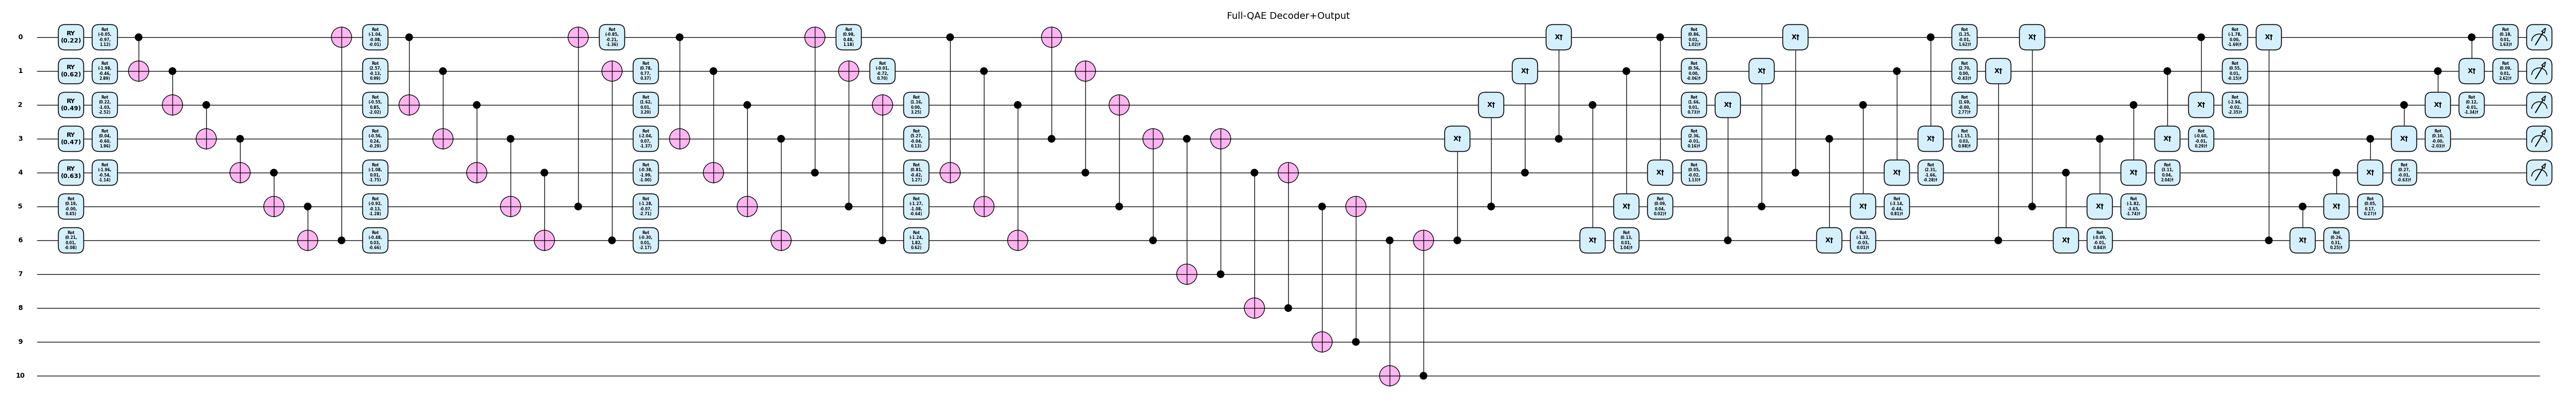

In [31]:
### Create a test model and reconstruct data from noise

opt_params = hist_params[stats[0]]
wires = list(range(n_wires))
test_qae = full_qae(wires, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot, add_outseq=False, invert_dec=True)
test_qae_model = qml.QNode(test_qae, dev)
draw_circuit(test_qae_model, scale=0.7, title='Full-QAE Decoder+Output', level='device') \
    (opt_params, y_test_noisy_tens[0]) # expansion_strategy='device'/'gradient'

In [32]:
### Reconstruct pure and noisy training TSs
pred_train_from_pure_tens = np.stack([qae_model(opt_params, x) for x in y_train_pure_tens], requires_grad=False)
pred_test_from_pure_tens = np.stack([qae_model(opt_params, x) for x in y_test_pure_tens], requires_grad=False)
pred_train_from_noisy_tens = np.stack([qae_model(opt_params, x) for x in y_train_noisy_tens], requires_grad=False)
pred_test_from_noisy_tens = np.stack([qae_model(opt_params, x) for x in y_test_noisy_tens], requires_grad=False)

### Flatten recovered TSs
pred_train_from_pure_flat = ts_wind_flatten_avg(pred_train_from_pure_tens, wind_step)
pred_test_from_pure_flat = ts_wind_flatten_avg(pred_test_from_pure_tens, wind_step)
pred_train_from_noisy_flat = ts_wind_flatten_avg(pred_train_from_noisy_tens, wind_step)
pred_test_from_noisy_flat = ts_wind_flatten_avg(pred_test_from_noisy_tens, wind_step)

In [33]:
### Calculate metrics to show in charts
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mse_train_pure_vs_noisy = mean_squared_error(y_train_pure_flat, y_train_noisy_flat)
mse_train_pure_vs_rec_from_noisy = mean_squared_error(y_train_pure_flat, pred_train_from_noisy_flat)
mse_test_pure_vs_noisy = mean_squared_error(y_test_pure_flat, y_test_noisy_flat)
mse_test_pure_vs_rec_from_noisy = mean_squared_error(y_test_pure_flat, pred_test_from_noisy_flat)

print(f'MSE train pure vs noise vs recovered = {mse_train_pure_vs_noisy:0.8f}, {mse_train_pure_vs_rec_from_noisy:0.8f}')
print(f'MSE test  pure vs noise vs recovered = {mse_test_pure_vs_noisy:0.8f}, {mse_test_pure_vs_rec_from_noisy:0.8f}')

MSE train pure vs noise vs recovered = 0.00343473, 0.01042719
MSE test  pure vs noise vs recovered = 0.00341891, 0.01098995


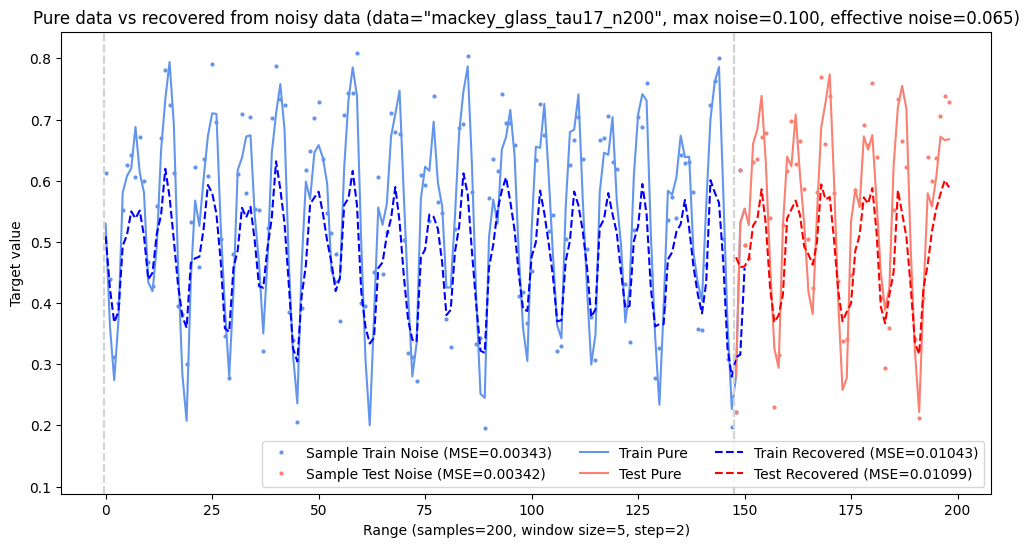

In [34]:
### Plot the original and recovered data with added performance metrics

# Prepare X, y lists for plotting
X_list = [X_train_pure_tens[0], X_test_pure_tens[0], 
          X_train_pure_tens[0], X_test_pure_tens[0], 
          X_train_pure_tens[0], X_test_pure_tens[0]]
y_list = [y_train_noisy_flat, y_test_noisy_flat,
          y_train_pure_flat, y_test_pure_flat, 
          pred_train_from_noisy_flat, pred_test_from_noisy_flat]

print()
multi_plot_flat_ts(y_list, X_list=X_list,
    colors = ['none', 'none',
              'cornflowerblue', 'salmon',
              'blue', 'red'], 
    marker_colors=['cornflowerblue', 'salmon', 
                   'linen', 'linen',
                   'linen', 'linen'],
    labels = [f'Sample Train Noise (MSE={mse_train_pure_vs_noisy:0.5f})', 
              f'Sample Test Noise (MSE={mse_test_pure_vs_noisy:0.5f})', 
              'Train Pure', 'Test Pure', 
              f'Train Recovered (MSE={mse_train_pure_vs_rec_from_noisy:0.5f})', 
              f'Test Recovered (MSE={mse_test_pure_vs_rec_from_noisy:0.5f})'],
    lines = ['none', 'none', 'solid', 'solid', 'dashed', 'dashed'], #ylim=(0, 3.5), 
    markers = ['.', '.', 'none', 'none', 'none', 'none'], legend_cols=3,
    title=f'Pure data vs recovered from noisy data (data="{DATA_ID}", max noise={noise:0.3f}, effective noise={calc_noise:0.3f})',
    xlabel=f'Range (samples={samples}, window size={wind_size}, step={wind_step})',
    save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/train_org_vs_recovered.eps'
    )
print()

## References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

4. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021

# Software in use

In [35]:
!pip list | grep -E 'PennyLane|torch|jax'

jax                       0.4.28
jax-cuda12-pjrt           0.4.28
jax-cuda12-plugin         0.4.28
jaxlib                    0.4.28
PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
PennyLane-Rigetti         0.40.0
torch                     2.6.0+cu126
torch-geometric           2.6.1
torchaudio                2.6.0+cu126
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.21.0+cu126
